In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##  The idea is to either merge the ToN and BoT datasets into one or use just ToN

In [2]:
import pandas as pd
df_ton = pd.read_csv('/content/drive/MyDrive/datasets/ton/NF-ToN-IoT.csv')
df_features = pd.read_csv('/content/drive/MyDrive/datasets/ton/NetFlow_v1_Features.csv')

#df_bot = pd.read_csv('/content/drive/MyDrive/datasets/bot/NF-BoT-IoT.csv')
#df_features_b = pd.read_csv('/content/drive/MyDrive/datasets/bot/NetFlow_v1_Features.csv')

df_ton.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign


## Features of both files prove to be the same. No need to include them twice.

In [3]:
#df_bot.head()

In [4]:
df_features.head()

,Feature,Description
0,IPV4_SRC_ADDR,IPv4 source address
1,IPV4_DST_ADDR,IPv4 destination address
2,L4_SRC_PORT,IPv4 source port number
3,L4_DST_PORT,IPv4 destination port number
4,PROTOCOL,IP protocol identifier byte


In [5]:
df_ton.Attack.unique()

array(['Benign', 'dos', 'injection', 'ddos', 'scanning', 'password',
       'mitm', 'xss', 'backdoor', 'ransomware'], dtype=object)

## Need to group DDOS and DOS into one col -- DDOS/DOS, MITM and SCANNING into reconnaissance

In [6]:
df_ton = df_ton.drop(df_ton[df_ton["Attack"] == "Benign"].index)
df_ton.loc[df_ton["Attack"].isin(["ddos", "dos"]), "Attack"] = "DDoS/DoS"
df_ton.loc[df_ton["Attack"].isin(["scanning", "mitm"]), "Attack"] = "Reconnaissance"
df_ton.loc[df_ton["Attack"].isin(["ransomware", "backdoor"]), "Attack"] = "Ransomware/Backdoor"
df_ton.loc[df_ton["Attack"].isin(["Ransomware/Backdoor", "Reconnaissance","xss"]), "Attack"] = "Other Malicious Activities"
#df_ton.loc[df_ton["Attack"].isin(["Reconnaissance", "Ransomware/Backdoor"]), "Attack"] = "Ransomware/Backdoor/Reconnaissance"
df_ton.drop(columns = ["Label"], inplace = True)
df_ton.Attack.unique()



array(['DDoS/DoS', 'injection', 'Other Malicious Activities', 'password'],
      dtype=object)

## Same columns (x), different target (y) - merging

In [7]:
#optional
"""
l1 = len(df_ton)
l2 = len(df_bot)

df = pd.merge(df_ton, df_bot, on=['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL',\
                                  'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS',\
                                  'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack'], how='outer')

l = len(df)
assert l == (l1+l2)
print(f"Merged dataframe number of rows: {l}\nUnique targets: {', '.join([x for x in df.Attack.unique()])}")
"""
df = df_ton
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack
11,192.168.1.31,60641,192.168.1.1,53,17,5.0,108,108,2,2,0,4,DDoS/DoS
12,192.168.1.31,60641,192.168.1.1,53,17,5.0,108,108,2,2,0,4,injection
13,192.168.1.31,60641,192.168.1.1,53,17,5.0,108,108,2,2,0,4,DDoS/DoS
14,192.168.1.31,38524,192.168.1.1,53,17,5.0,100,100,2,2,0,5,injection
15,192.168.1.31,38524,192.168.1.1,53,17,5.0,100,100,2,2,0,5,DDoS/DoS


## Analysis of dataset validity

Checking the dataset for invalid values and performing minor preprocessing

In [8]:
null_values = df.isnull().sum()
print(f"Null or NaN values in the merged DataFrame:\n{null_values}")
df.describe()

Null or NaN values in the merged DataFrame:
IPV4_SRC_ADDR                 0
L4_SRC_PORT                   0
IPV4_DST_ADDR                 0
L4_DST_PORT                   0
PROTOCOL                      0
L7_PROTO                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
TCP_FLAGS                     0
FLOW_DURATION_MILLISECONDS    0
Attack                        0
dtype: int64


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS
count,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06,1.108995e+06
mean,4.721514e+04,2.296271e+02,6.598119e+00,2.551343e+01,4.984755e+02,2.443873e+03,5.478282e+00,5.015118e+00,2.265866e+01,1.270001e+03
std,8.228782e+03,7.859514e+02,2.494307e+00,3.559058e+01,4.635882e+03,4.923607e+03,1.054078e+02,6.989633e+00,7.084663e+00,9.236826e+03
min,7.400000e+01,7.000000e+00,6.000000e+00,0.000000e+00,4.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.015000e+04,8.000000e+01,6.000000e+00,7.000000e+00,1.120000e+02,6.000000e+01,2.000000e+00,1.000000e+00,1.800000e+01,2.000000e+00
50%,4.737000e+04,8.000000e+01,6.000000e+00,7.000000e+00,4.640000e+02,1.664000e+03,5.000000e+00,5.000000e+00,2.700000e+01,1.560000e+02
75%,5.442400e+04,8.000000e+01,6.000000e+00,7.178000e+00,5.630000e+02,2.365000e+03,5.000000e+00,6.000000e+00,2.700000e+01,4.210000e+02
max,6.553400e+04,4.978800e+04,1.700000e+01,2.490000e+02,7.576800e+05,7.858210e+05,1.894200e+04,2.383000e+03,3.100000e+01,4.291973e+06


## Checking numeric cols

In [9]:
numeric_columns = df.select_dtypes(include=['number'])
print(f"Numeric Columns: {', '.join([str(y) for y in numeric_columns.columns])}\nData types:\n{numeric_columns.dtypes}")

Numeric Columns: L4_SRC_PORT, L4_DST_PORT, PROTOCOL, L7_PROTO, IN_BYTES, OUT_BYTES, IN_PKTS, OUT_PKTS, TCP_FLAGS, FLOW_DURATION_MILLISECONDS
Data types:
L4_SRC_PORT                     int64
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
dtype: object


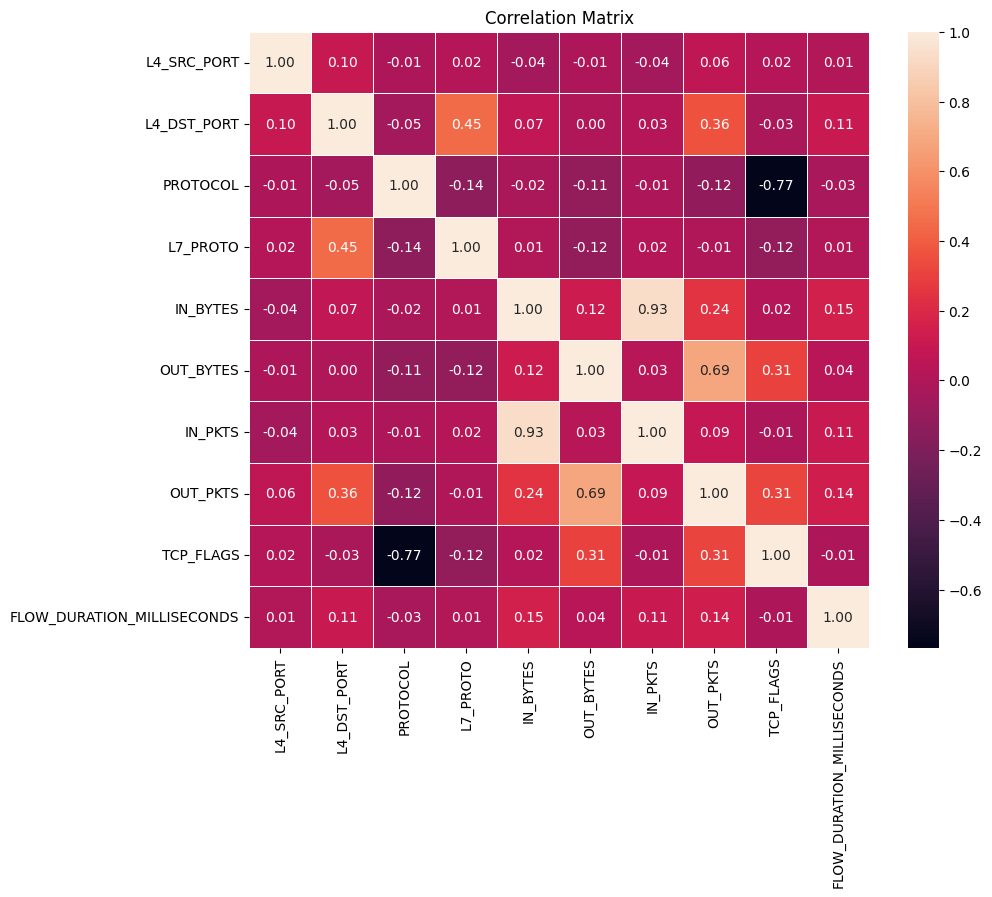

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


corr = numeric_columns.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, cmap='rocket', annot=True, fmt=".2f", linewidths=.5)

plt.title("Correlation Matrix")
plt.show()

Acceptable, no potential multicolinenarity issues

---
## Transforming the IP addr format into an acceptable format

In [11]:
def transform_ip(ip_address):
    #split into octets
    octets = ip_address.split('.')
    #format to 3 digs
    formatted_octets = [f'{int(octet):03d}' for octet in octets]
    return ''.join(formatted_octets)

In [12]:
test = "192.168.0.1"

transform_ip(test)

'192168000001'

Deep copying df to secure the original dataframe

In [13]:
df_c = df.copy(deep = True) # deep copy to ensure copy does not depend on the original (no altering the original dataframe)
print(f"Data check: {df_c == df}")
print(f"Memory check:{id(df_c) == id(df)}")


Data check:          IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
11                True         True           True         True      True   
12                True         True           True         True      True   
13                True         True           True         True      True   
14                True         True           True         True      True   
15                True         True           True         True      True   
...                ...          ...            ...          ...       ...   
1379269           True         True           True         True      True   
1379270           True         True           True         True      True   
1379271           True         True           True         True      True   
1379272           True         True           True         True      True   
1379273           True         True           True         True      True   

         L7_PROTO  IN_BYTES  OUT_BYTES  IN_PKTS  OUT_PKTS  TCP_

In [14]:
df_c['IPV4_SRC_ADDR'], df_c["IPV4_DST_ADDR"] = df_c['IPV4_SRC_ADDR'].apply(transform_ip), df_c['IPV4_DST_ADDR'].apply(transform_ip)
df_c

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack
11,192168001031,60641,192168001001,53,17,5.0,108,108,2,2,0,4,DDoS/DoS
12,192168001031,60641,192168001001,53,17,5.0,108,108,2,2,0,4,injection
13,192168001031,60641,192168001001,53,17,5.0,108,108,2,2,0,4,DDoS/DoS
14,192168001031,38524,192168001001,53,17,5.0,100,100,2,2,0,5,injection
15,192168001031,38524,192168001001,53,17,5.0,100,100,2,2,0,5,DDoS/DoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,192168001031,58032,192168001194,80,6,7.0,216,180,4,3,18,9433,DDoS/DoS
1379270,192168001031,58034,192168001194,80,6,7.0,216,180,4,3,18,9221,DDoS/DoS
1379271,192168001031,58036,192168001194,80,6,7.0,216,180,4,3,18,9656,DDoS/DoS
1379272,192168001031,58038,192168001194,80,6,7.0,216,180,4,3,18,10046,DDoS/DoS


No meaningful relationship between Attack column values

In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_c['Encoded_Attack'] = label_encoder.fit_transform(df_c['Attack'])
df_c[['Attack', 'Encoded_Attack']]

,Attack,Encoded_Attack
11,DDoS/DoS,0
12,injection,2
13,DDoS/DoS,0
14,injection,2
15,DDoS/DoS,0
...,...,...
1379269,DDoS/DoS,0
1379270,DDoS/DoS,0
1379271,DDoS/DoS,0
1379272,DDoS/DoS,0


In [16]:
!pip install joblib

In [17]:
import joblib

encoder_filename = "encoder.save"
joblib.dump(label_encoder, encoder_filename)

['encoder.save']

In [18]:
# optional, remove the agnostic features
#df_c = df_c.drop(columns=['OUT_BYTES','TCP_FLAGS'])
#df_c.columns

In [19]:
#this was used for DL approach which was deemed unsuccessful (~50% acc. on weighted crossentropy, 64% on balanced)

from sklearn.model_selection import train_test_split

X = df_c.drop(['Attack', 'Encoded_Attack'], axis=1)
y = df_c['Encoded_Attack']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 776296
Testing set size: 166350


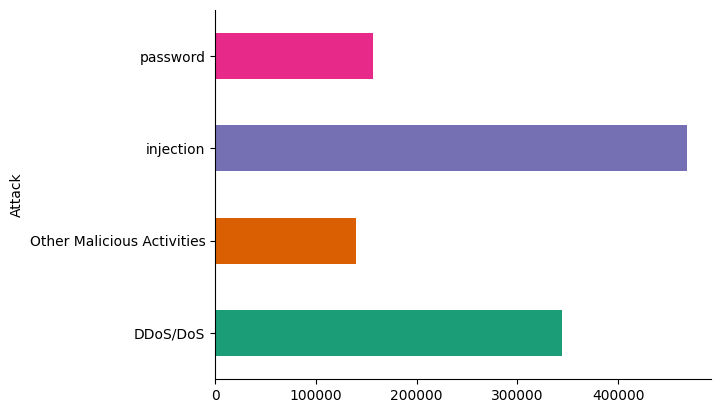

In [20]:
from matplotlib import pyplot as plt
import seaborn as sns
df_c.groupby('Attack').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Checking the similary of classes

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 2 1 3] ['DDoS/DoS' 'injection' 'Other Malicious Activities' 'password']


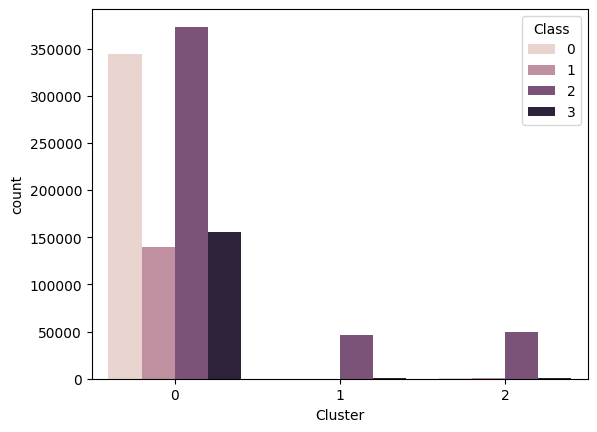

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
y_clusters = kmeans.fit_predict(X)

print(y.unique(), label_encoder.inverse_transform(y.unique()))

df_clusters = pd.DataFrame({'Cluster': y_clusters, 'Class': y})

sns.countplot(x='Cluster', hue='Class', data=df_clusters)
plt.show()

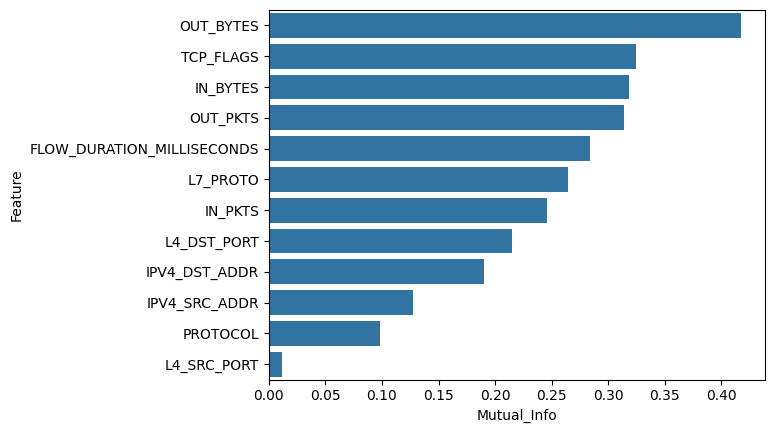

In [22]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y)

df_mutual_info = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mutual_info})

sns.barplot(x='Mutual_Info', y='Feature', data=df_mutual_info.sort_values(by='Mutual_Info', ascending=False))
plt.show()

### OUT_BYTES, IN_BYTES seem to contain a lot of information that is class-agnostic...

### Taking a few steps back to drop them (leaving it optional)

In [23]:
df_c

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Attack,Encoded_Attack
11,192168001031,60641,192168001001,53,17,5.0,108,108,2,2,0,4,DDoS/DoS,0
12,192168001031,60641,192168001001,53,17,5.0,108,108,2,2,0,4,injection,2
13,192168001031,60641,192168001001,53,17,5.0,108,108,2,2,0,4,DDoS/DoS,0
14,192168001031,38524,192168001001,53,17,5.0,100,100,2,2,0,5,injection,2
15,192168001031,38524,192168001001,53,17,5.0,100,100,2,2,0,5,DDoS/DoS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,192168001031,58032,192168001194,80,6,7.0,216,180,4,3,18,9433,DDoS/DoS,0
1379270,192168001031,58034,192168001194,80,6,7.0,216,180,4,3,18,9221,DDoS/DoS,0
1379271,192168001031,58036,192168001194,80,6,7.0,216,180,4,3,18,9656,DDoS/DoS,0
1379272,192168001031,58038,192168001194,80,6,7.0,216,180,4,3,18,10046,DDoS/DoS,0


## The fun part

Tried methods:
* Ensemble (from 3 to 7 models, max top 1 accuracy 65%)
* Hypertuned NN (max top 1 64%)
* Clustering (KMeans -- top 1 48%)
* **Cosine similarity** (top 1 **~69%**)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import mode

acc_top2 = 0
trials = 100
n = 100

for x in range(1, trials):
    print(f"Trial {x}\n")
    df_test = df_c.sample(n=n, random_state=x)

    X_c = df_c[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS']]
    y_c = df_c['Encoded_Attack']

    X_test = df_test[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS']]
    y_test = df_test['Encoded_Attack']

    cosine_similarities = cosine_similarity(X_test, X_c)

    most_similar_indices = cosine_similarities.argsort(axis=1)[:, ::-1]

    first_most_similar_indices = most_similar_indices[:, 0]
    second_most_similar_indices = most_similar_indices[:, 1]

    combined_predictions = (y_c.iloc[first_most_similar_indices].values == y_test.values) | (y_c.iloc[second_most_similar_indices].values == y_test.values)

    accuracy_top2 = sum(combined_predictions) / len(combined_predictions)
    acc_top2 += accuracy_top2
    print(f"Top-2 Accuracy: {accuracy_top2:.2%}")

print(f"Average Top-2 Accuracy: {acc_top2/trials:.2%}")



Trial 1

Top-2 Accuracy: 92.00%
Trial 2

Top-2 Accuracy: 94.00%
Trial 3

Top-2 Accuracy: 90.00%
Trial 4

Top-2 Accuracy: 90.00%
Trial 5

Top-2 Accuracy: 95.00%
Trial 6

Top-2 Accuracy: 91.00%
Trial 7

Top-2 Accuracy: 91.00%
Trial 8

Top-2 Accuracy: 94.00%
Trial 9

Top-2 Accuracy: 89.00%
Trial 10

Top-2 Accuracy: 88.00%
Trial 11

Top-2 Accuracy: 90.00%
Trial 12

Top-2 Accuracy: 94.00%
Trial 13

Top-2 Accuracy: 90.00%
Trial 14

Top-2 Accuracy: 88.00%
Trial 15

Top-2 Accuracy: 96.00%
Trial 16

Top-2 Accuracy: 87.00%
Trial 17

Top-2 Accuracy: 86.00%
Trial 18

Top-2 Accuracy: 90.00%
Trial 19

Top-2 Accuracy: 92.00%
Trial 20

Top-2 Accuracy: 90.00%
Trial 21

Top-2 Accuracy: 95.00%
Trial 22

Top-2 Accuracy: 92.00%
Trial 23

Top-2 Accuracy: 91.00%
Trial 24

Top-2 Accuracy: 91.00%
Trial 25

Top-2 Accuracy: 90.00%
Trial 26

Top-2 Accuracy: 92.00%
Trial 27

Top-2 Accuracy: 92.00%
Trial 28

Top-2 Accuracy: 99.00%
Trial 29

Top-2 Accuracy: 89.00%
Trial 30

Top-2 Accuracy: 91.00%
Trial 31

Top-2 Acc

In [25]:
df_c.to_csv('data.csv', index=False)